# Preparation

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, cut_tree

from counterfactualgp.gp import GP
from counterfactualgp.mean import LinearWithBsplinesBasis
from counterfactualgp.treatment import DummyTreatment, Treatment
from counterfactualgp.mpp import BinaryActionModel
from counterfactualgp.cov import iid_cov, se_cov, linear_cov
from counterfactualgp.bsplines import BSplines
from counterfactualgp.lmm import LinearMixedModel, learn_lmm

In [2]:
with open('dataset/data_set_bspline_3classes.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
low, high = 0.0, 24.0
num_basis = 5
bsplines_degree = 3
n_clusters = 3
basis = BSplines(low, high, num_basis, bsplines_degree, boundaries='space')

In [4]:
def predict(gp, y, x, x_star):
    t, rx = x
    t_star, rx_star = x_star
    yhat, cov_hat = gp.predict((t_star, rx_star), y, (t, rx))
        
    return yhat, cov_hat

In [5]:
def draw_bsplines(basis, coef, n_classes):
    t = np.linspace(basis._low, basis._high, num=100)

    fig, axes = plt.subplots(nrows=1, ncols=n_classes, sharey=True, figsize=(4*n_classes, 4))
    for i,w in enumerate(coef):
        y = np.dot(basis.design(t), w)
        if isinstance(axes, np.ndarray): 
            axes[i].plot(t, y)
        else:
            axes.plot(t, y)

    plt.show()

In [6]:
def draw_samples(gp, samples, t_star, rx_star, nrow=3, ncol=3, title='',
                 truncated_time=None, copy_truncated_rx=False):
    
    def _concat_x(t1, rx1, t2, rx2):
        t = np.concatenate([t1, t2])
        rx = np.concatenate([rx1, rx2])
        idx = np.argsort(t)
        return t[idx], rx[idx]
    
    # reset `rx_star` if not truncated
    if truncated_time is not None:
        rx_star[t_star <= truncated_time] = 0
    else:
        rx_star = np.zeros(rx_star.shape[0])
    
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6), sharey=True)
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j            
            y, x = samples[idx]
            t, rx = x
            
            if truncated_time is not None:
                _y = y[t <= truncated_time]
                _t = t[t <= truncated_time]
                _rx = rx[t <= truncated_time]
                if copy_truncated_rx:
                    _t_star, _rx_star = _concat_x(t, rx, t_star, rx_star)
                else:
                    _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            else:
                _y, _t, _rx = y, t, rx
                _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            
            yhat, cov_hat = predict(gp, _y, (_t, _rx), (_t_star, _rx_star))
            y_std = np.diag(cov_hat)
            
            axes[i, j].plot(_t_star, yhat, color='b')
            axes[i, j].scatter(t, y, marker='o', color='r')
            for _tt, _rx in zip(t, rx):
                if _rx == 1:
                    axes[i, j].axvline(x=_tt, color = 'y')
            axes[i, j].fill_between(_t_star, yhat - y_std, yhat + y_std,
                                 alpha=0.2, color='k')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color='r', ls='--')
    fig.suptitle(title)
    plt.show()

# Clustering

In [7]:
def cluster_trajectories(data, xlim, basis, n_clusters, method='complete'):
    data = [(y, basis.design(x), basis.design(x)) for y,(x,_) in data]
    lmm = learn_lmm(data)
    
    beta, Sigma, v = lmm.param_copy()
    coef = np.array([lmm.posterior(*x)[0] for x in data])
    link = linkage(coef, method)
    clusters = cut_tree(link, n_clusters).ravel()
    cluster_coef = np.ndarray((n_clusters, coef.shape[1]))
    for k in range(n_clusters):
        w = coef[clusters == k].mean(axis=0)
        cluster_coef[k] = w
    
    fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(4*n_clusters,4), sharex=True, sharey=True)
    t = np.linspace(low, high, num=100)
    for k in range(n_clusters):
        yhat = np.dot(basis.design(t), beta) + np.dot(basis.design(t), cluster_coef[k])
        axes[k].plot(t, yhat)
    plt.show()

    return cluster_coef

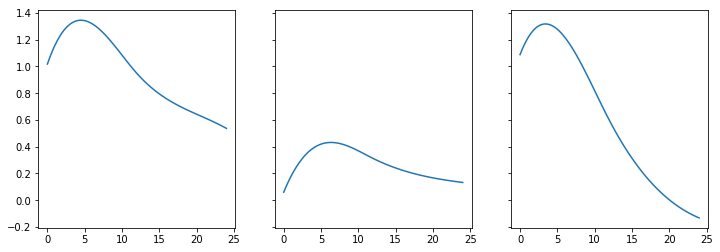

In [8]:
clustered_basis = cluster_trajectories(data['training2'], (low, high), basis, 3)

# Single GP

## Baseline GP without treatment

In [10]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (1.0, DummyTreatment()) )
bgp = GP(m, linear_cov(basis), tr, ac_fn=None)
bgp.fit(data['training2'], init = False)
print(bgp.params)

obj= 4244.424429628636
obj= 4049.8702915247372
obj= 3989.615823648743
obj= 3982.103221755088
obj= 3969.4432037151414
obj= 3945.1692273239337
obj= 3901.055432407186
obj= 3832.1131716047144
obj= 3807.3927959091216
obj= 3805.6613910142737
obj= 3805.604982787543
obj= 3805.560307172714
obj= 3805.5584687318847
obj= 3805.557980367357
obj= 3805.5579780768862
obj= 3805.5579780117896
obj= 3805.557978010912
obj= 3805.5579780108574
{'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-3.18679617,  1.79139855,  0.43401578,  0.19981863, -0.10248488]), 'ln_cov_y': array([-1.44368082]), 'ln_cov_w': array([-0.72111525])}


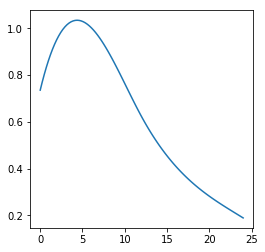

In [11]:
coef = [bgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

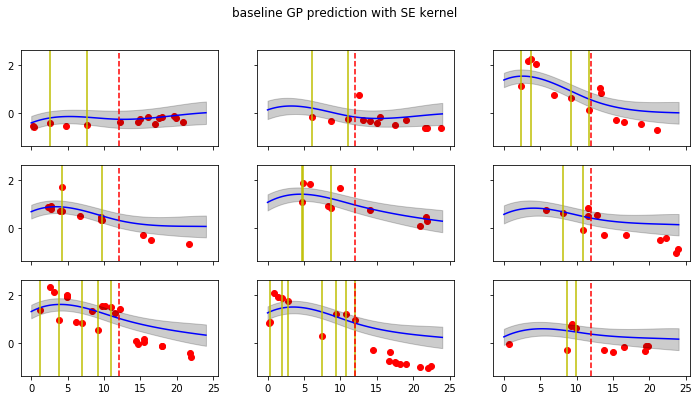

In [12]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', data['truncated_time'])

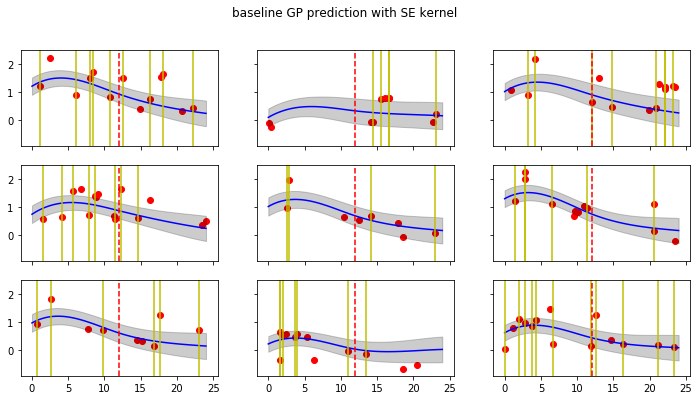

In [13]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', 
             data['truncated_time'], copy_truncated_rx=True)

## Baseline GP with treatment

In [14]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (1.0, Treatment(2.0)) )
bgp_rx = GP(m, linear_cov(basis), tr, ac_fn=None)
bgp_rx.fit(data['training2'], init = False)
print(bgp_rx.params)

obj= 3945.028817918209
obj= 2961.7420659060895
obj= 2768.0958400581867
obj= 2752.8197120890177
obj= 2725.34120375492
obj= 2478.7385075302122
obj= 2422.907918834849
obj= 2349.5636514042453
obj= 2223.8664522651434
obj= 2124.3469158614816
obj= 2004.0912368735064
obj= 1997.783822808296
obj= 1991.3426703077982
obj= 1991.058670951904
obj= 1990.9787870383636
obj= 1990.974788163853
obj= 1990.9746130708086
obj= 1990.9746116236433
obj= 1990.9746115683065
obj= 1990.9746115669745
obj= 1990.9746115669618
obj= 1990.974611566961
{'effects_window_F': array([2.]), 'treatment': array([0.49244814]), 'ln_cov_w': array([-1.02374822]), 'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-0.45595025,  1.09456329,  0.23616264, -0.12903853, -0.29503986]), 'ln_cov_y': array([-2.3425385])}


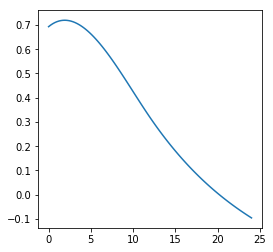

In [15]:
coef = [bgp_rx.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

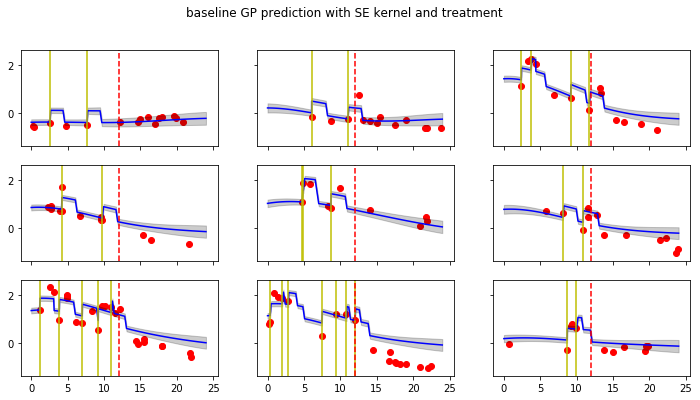

In [16]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

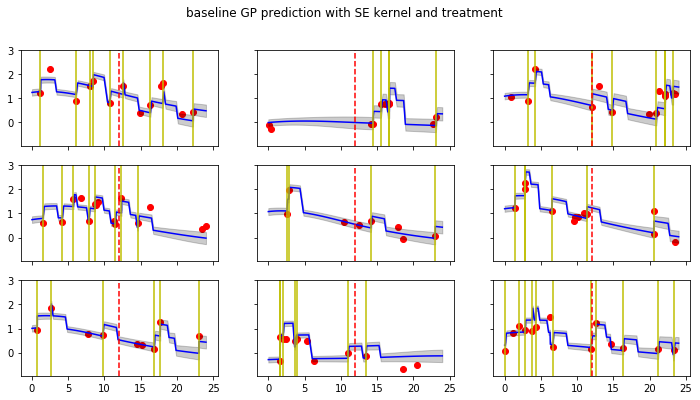

In [17]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Counterfactual GP

In [18]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
cgp = GP(m, linear_cov(basis), tr, ac_fn=ac)
cgp.fit(data['training2'], init = False)
print(cgp.params)

obj= [6797.3092323]
obj= [5620.23695181]
obj= [5527.33117213]
obj= [5394.6726768]
obj= [5376.69502971]
obj= [5372.18182641]
obj= [5330.30535893]
obj= [5312.88080225]
obj= [5280.11769764]
obj= [5222.93810062]
obj= [5158.60151963]
obj= [5151.68667729]
obj= [5143.51769162]
obj= [5143.10597166]
obj= [5143.01279117]
obj= [5142.9990473]
obj= [5142.99834705]
obj= [5142.99824308]
obj= [5142.99824218]
obj= [5142.99824209]
obj= [5142.99824209]
obj= [5142.99824209]
{'effects_window_F': array([2.]), 'treatment': array([0.53442107]), 'ln_cov_w': array([-0.9795167]), 'action': array([0.38270284]), 'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-1.1375599 ,  1.23151471,  0.17948341, -0.09869716, -0.42829459]), 'ln_cov_y': array([-2.39419109])}


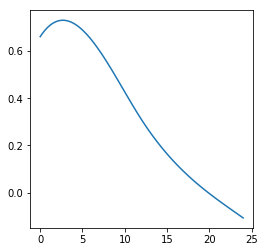

In [19]:
coef = [cgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

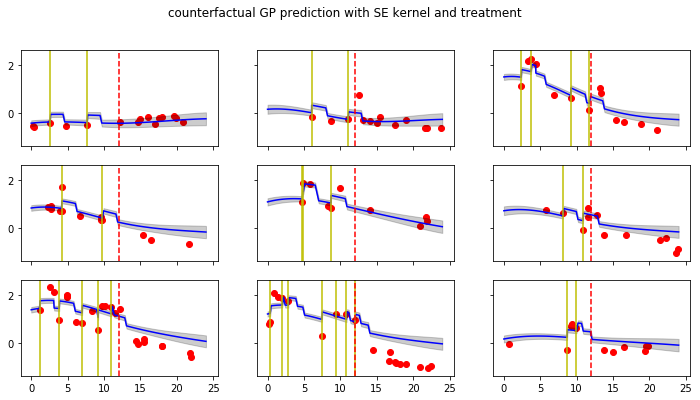

In [20]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

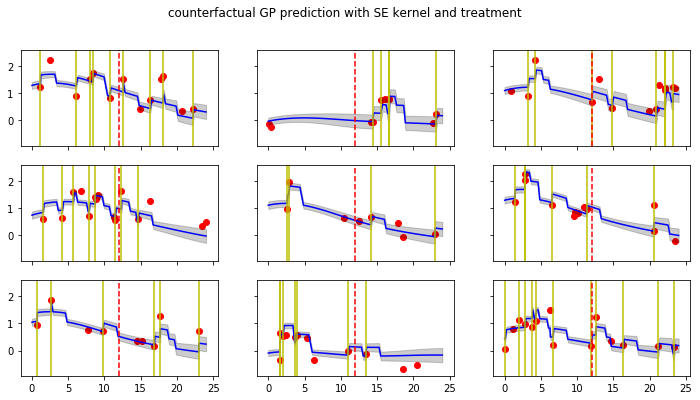

In [21]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

# Mixture of GPs

## Mixture of BGPs without treatment

obj= 4251.419226257313
obj= 4008.6205581709537
obj= 3930.750728239385
obj= 3910.929230857212
obj= 3904.699024355435
obj= 3872.6399941654004
obj= 3853.564349061017
obj= 3825.6332527794875
obj= 3793.819399287644
obj= 3780.5162019343657
obj= 3768.0177884526533
obj= 3762.2109820496753
obj= 3759.4745485749577
obj= 3755.4609261464348
obj= 3748.4460316989903
obj= 3736.95913988773
obj= 3730.264730591933
obj= 3726.874391342136
obj= 3724.853742018087
obj= 3723.5425194108125
obj= 3722.388341719864
obj= 3722.041853418578
obj= 3721.9857825587555
obj= 3721.973036539335
obj= 3721.964594221372
obj= 3721.96406406957
obj= 3721.963838528838
obj= 3721.963820217786
obj= 3721.9638156433275
obj= 3721.9638153969154
obj= 3721.9638150241844
obj= 3721.963814887317
obj= 3721.963814881876
obj= 3721.9638148792596
obj= 3721.9638148791046
obj= 3721.9638148790855
{'classes_prob_logit': array([ 0.11653209, -0.12339787,  0.00686578]), 'ln_cov_w': array([-2.17312201]), 'linear_with_bsplines_basis_mean_coef2': array([-4.3

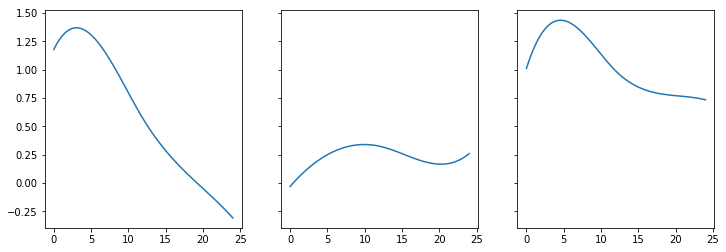

In [22]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=clustered_basis[i]))
tr = []
tr.append( (1.0, DummyTreatment()) )
mgp = GP(m, linear_cov(basis), tr, ac_fn=None)
mgp.fit(data['training2'], init = False)
print(mgp.params)

coef = [mgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

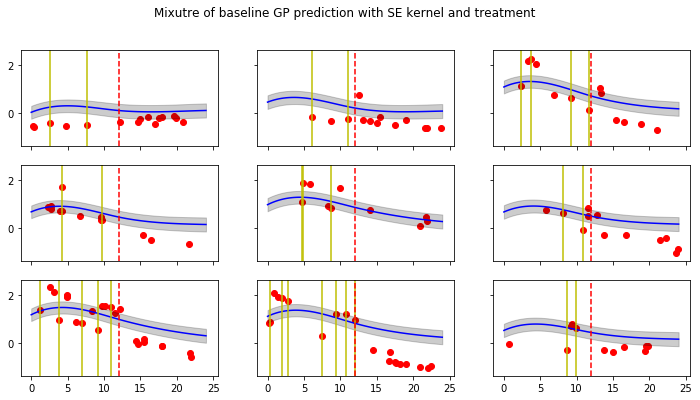

In [23]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

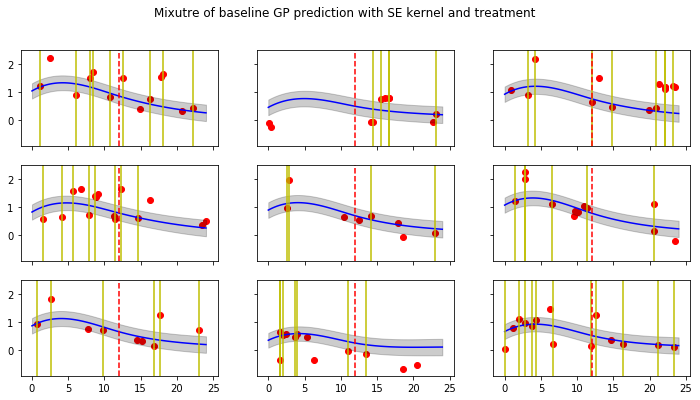

In [24]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Mixture of BGPs with treatment

obj= 3921.2928015507564
obj= 2757.406631686472
obj= 2468.9081130126383
obj= 2391.3334857135787
obj= 2284.660559521253
obj= 2205.8847932621575
obj= 2089.104882873869
obj= 2077.1640634780833
obj= 2059.4679377031644
obj= 2030.2700305301216
obj= 2001.7211244291452
obj= 1996.5810001718953
obj= 1992.0286437054924
obj= 1991.5833554291808
obj= 1991.2085639031552
obj= 1991.176844744125
obj= 1991.118804204723
obj= 1991.0262784707752
obj= 1990.9661082797402
obj= 1990.9556254325478
obj= 1990.9391175909368
obj= 1990.9216070553753
obj= 1990.908891440939
obj= 1990.8868931719367
obj= 1990.855294557529
obj= 1990.819356629066
obj= 1990.7497768446192
obj= 1990.6391788759784
obj= 1990.5145134131124
obj= 1989.9064346344908
obj= 1989.8430607271682
obj= 1989.7353112358194
obj= 1988.8641508090693
obj= 1985.103939139419
obj= 1983.8858144275102
obj= 1981.9319809731523
obj= 1979.1611819186066
obj= 1975.252400333333
obj= 1968.3849590362652
obj= 1956.4508687281727
obj= 1937.4317685997314
obj= 1918.3869102336357
ob

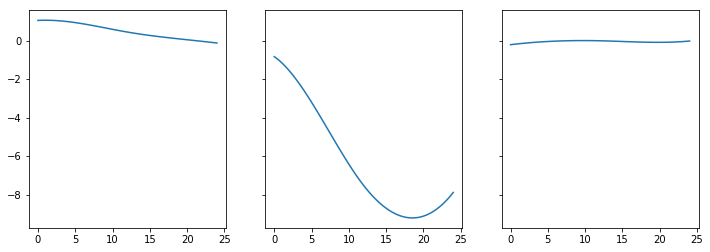

In [25]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=clustered_basis[i]))
tr = []
tr.append( (1.0, Treatment(2.0)) )
mgp_rx = GP(m, linear_cov(basis), tr, ac_fn=None)
mgp_rx.fit(data['training2'], init = False)
print(mgp_rx.params)

coef = [mgp_rx.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

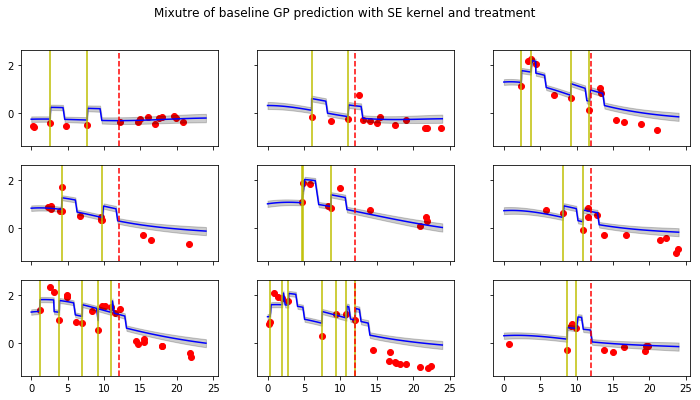

In [26]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

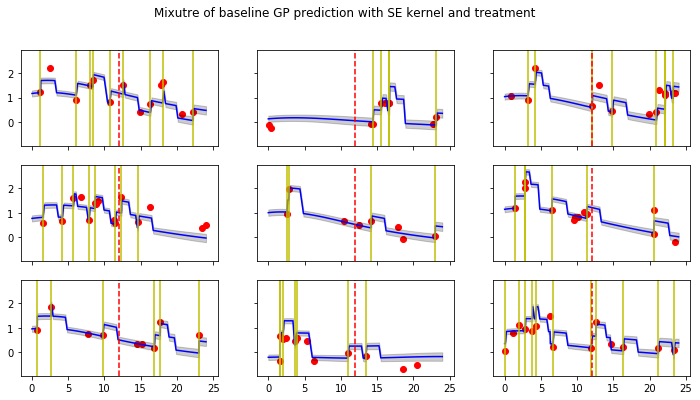

In [27]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Mixture of CGPs

obj= [6798.52516757]
obj= [5623.91400011]
obj= [5388.93610585]
obj= [5261.63780545]
obj= [5205.61182227]
obj= [5178.36267922]
obj= [5133.65849234]
obj= [5129.09638471]
obj= [5123.03638492]
obj= [5119.96114746]
obj= [5114.52840349]
obj= [5104.30696614]
obj= [5087.14362191]
obj= [5079.35128745]
obj= [5073.62537043]
obj= [5062.70229264]
obj= [5043.91043085]
obj= [5011.66949428]
obj= [4978.06730847]
obj= [4968.34113392]
obj= [4964.09387584]
obj= [4962.3025788]
obj= [4960.33342329]
obj= [4959.30864624]
obj= [4958.7114587]
obj= [4958.55226649]
obj= [4958.51424208]
obj= [4958.50412022]
obj= [4958.50095747]
obj= [4958.49970999]
obj= [4958.49960988]
obj= [4958.49950989]
obj= [4958.49950845]
obj= [4958.49950775]
obj= [4958.49950773]
obj= [4958.49950772]
obj= [4958.49950772]
obj= [4958.49950772]
obj= [4958.49950772]
obj= [4958.49950772]
{'classes_prob_logit': array([ 0.07299916, -0.16476873,  0.09176958]), 'effects_window_F': array([2.]), 'treatment': array([0.52022119]), 'ln_cov_w': array([-2.63

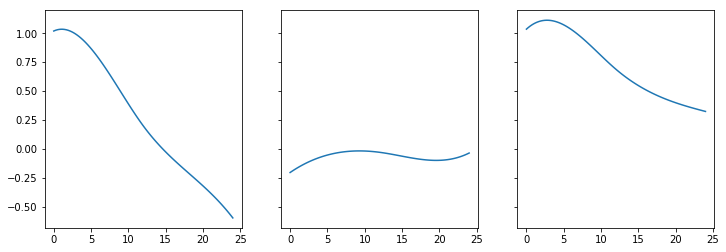

In [28]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=clustered_basis[i]))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
mcgp = GP(m, linear_cov(basis), tr, ac_fn=ac)
mcgp.fit(data['training2'], init = False)
print(mcgp.params)

coef = [mcgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

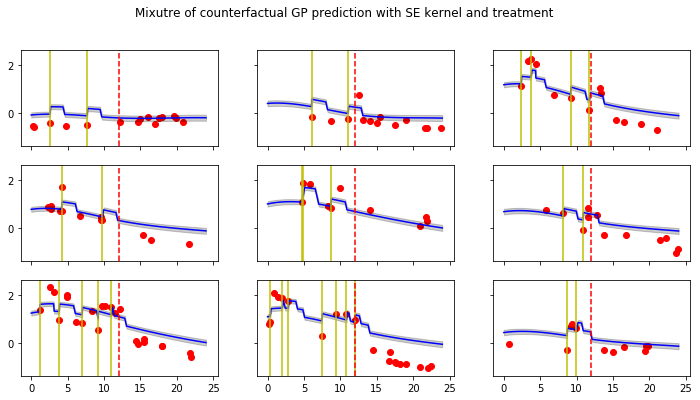

In [29]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

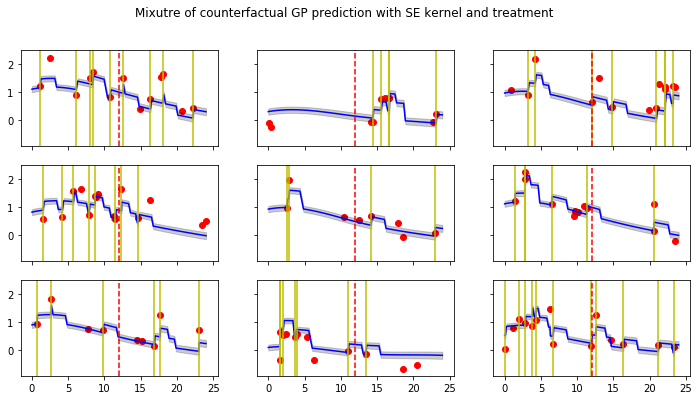

In [30]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

# MSE

In [31]:
def MSE(gp, samples, truncated_time):
    '''
    Calculate the MSE metric over points after `truncated_time`.
    '''
    s = 0.0
    for y, x in samples:
        t, rx = x
        idx = t <= truncated_time
        _y = y[idx]
        _t = t[idx]
        _rx = rx[idx]

        yhat, cov_hat = predict(gp, _y, (_t, _rx), (t, rx))
        s += np.sum((yhat[~idx] - y[~idx]) **2) / y[~idx].shape[0]
    
    return s / len(samples)

In [32]:
for s,gp in zip(['bgp', 'bgp_rx', 'cgp', 'mbgp', 'mbgp_rx', 'mcgp'], 
                 [bgp, bgp_rx, cgp, mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['testing1'], data['truncated_time']))

bgp 0.29346955623866444
bgp_rx 0.13202744053973958
cgp 0.1549590525154437
mbgp 0.3080967566577025
mbgp_rx 0.13622537023740594
mcgp 0.15761459473023073


In [33]:
for s, gp in zip(['bgp', 'bgp_rx', 'cgp', 'mbgp', 'mbgp_rx', 'mcgp'], 
                 [bgp, bgp_rx, cgp, mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['training2'], data['truncated_time']))

bgp 0.357811083128424
bgp_rx 0.16076364367883011
cgp 0.1976902318866449
mbgp 0.35647697490960495
mbgp_rx 0.1620885700746834
mcgp 0.20583082467789862
